In [1]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os

os.chdir(path)

SEED = 42

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [2]:
# %% --------------------------------------- Load data --------------------------------------------------------------------


# continuous features
cont = ['#_ppl_household', 'age', 'triglyceride', 'caffeine', 'lifetime_partners',
        'glycohemoglobin', 'CRP', 'tot_cholesterol', 'systolic_BP', 'diastolic_BP', 'BMI', 'waist_C',
        '#meals_fast_food',
        'min_sedetary', 'bone_mineral_density']

# categorical features
cat = ['race_ethnicity', 'edu_level', 'gender', 'marital_status', 'annual_HI',
       'doc_diabetes', 'how_healthy_diet', 'used_CMH',
       'health_insurance', 'doc_asthma', 'doc_overweight', 'doc_arthritis',
       'doc_CHF', 'doc_CHD', 'doc_heart_attack', 'doc_stroke',
       'doc_chronic_bronchitis', 'doc_liver_condition', 'doc_thyroid_problem',
       'doc_cancer', 'difficult_seeing', 'doc_kidney', 'broken_hip',
       'doc_osteoporosis', 'vigorous_activity', 'moderate_activity',
       'doc_sleeping_disorder', 'smoker', 'sexual_orientation',
       'alcoholic', 'herpes_2', 'HIV', 'doc_HPV', 'difficult_hearing', 'doc_COPD']

# multi-class features
cat_encode = ['race_ethnicity', 'edu_level', 'gender', 'marital_status', 'annual_HI', 'how_healthy_diet',
              'sexual_orientation']

# target binary feature
target = 'depressed'

df_raw = pd.read_csv('df_raw_v2.csv')

# bring year and target col to the beginning of df
year = df_raw.pop('year')
df_raw.insert(1, 'year', year)

dep = df_raw.pop('depressed')
df_raw.insert(2, 'depressed', dep)

# drop marijuana use
df_raw.drop(['used_marijuana'], axis=1, inplace=True)
# drop year?
df_raw.drop(['year'], axis=1, inplace=True)

In [3]:
# ---------------------------- Read in or Create Imputed Data -----------------------------
# FOR MLP/KNN IMPUTED DATA
df_mlp_impute = pd.read_csv('df_progressive_mlp_2.csv')
df_mlp_impute.drop(['year'], axis=1, inplace=True)
# df_knn_impute = pd.read_csv('df_progressive_knn_2.csv')
# df_knn_impute.drop(['year'],axis=1, inplace=True)

# FOR MEAN/MEDIAN IMPUTED DATA
# from nan_helper import nan_helper
# from mean_median_imputation import missing_values
#
# nan_df = nan_helper(df_raw)
# df_mean_50 = missing_values(df_raw, 0.50,0.50, 'mean')

In [4]:
# ---------------------------- Split, Encode, & Standardize --------------------------------

from sklearn.model_selection import train_test_split


# Function to One-hot-encode the categorical features
def one_hot_encode(df):
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)

    return (df_encode)


df = one_hot_encode(df_mlp_impute)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df[cont] = ss.fit_transform(df[cont])

In [5]:
# get the name of the features
features = np.setdiff1d(df.columns, [target])

# divide into training and testing
df_raw_train, df_raw_test = train_test_split(df, test_size=0.3, random_state=SEED)
# Reset the index
df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)
# Make a copy of df_raw_test
df_test = df_raw_test.copy(deep=True)

# split training into train and validation
df_train_2, df_val = train_test_split(df_train, test_size=0.3, random_state=SEED, stratify=df_train['depressed'])

# get feautre matrix
train_inputs = np.asarray(df_train_2[features])
test_inputs = np.asarray(df_test[features])
val_inputs = np.asarray(df_val[features])
train_target = np.asarray(df_train_2[target])
test_target = np.asarray(df_test[target])
val_target = np.asarray(df_val[target])

print('Training data shape:', df_train_2.shape)
print('Validation data shape:', df_val.shape)
print('Test data shape:', df_test.shape)

Training data shape: (15364, 85)
Validation data shape: (6585, 85)
Test data shape: (9408, 85)


In [6]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K

# The known number of output classes.
num_classes = 2

# Input image dimensions
in_shape = (84,)

# Convert class vectors to binary class matrices. This uses 1 hot encoding.
train_target_binary = keras.utils.to_categorical(train_target,2)
val_target_binary = keras.utils.to_categorical(val_target, num_classes)
test_target_binary = keras.utils.to_categorical(test_target, num_classes)

x_train = train_inputs.reshape(15364, 84,1)
x_val = val_inputs.reshape(6585,84,1)
x_test = test_inputs.reshape(9408, 84,1)


In [7]:
train_target_binary

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [25]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

model = Sequential()
model.add(Conv1D(32, (2), input_shape=(84,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(32, 2, activation="relu"))
model.add(BatchNormalization())
model.add(Conv1D(64, 2, activation="relu"))
model.add(BatchNormalization())
model.add(Conv1D(128, 2, activation="relu"))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))  # Intermediate linear layer that comes back to the kernel size
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 83, 32)            96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 83, 32)            128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 82, 32)            2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 82, 32)            128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 81, 64)            4160      
_________________________________________________________________
batch_normalization_18 (Batc (None, 81, 64)            256       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 80, 128)          

In [133]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
#
ros = RandomOverSampler(random_state=SEED)
def ROS(features, target):
    X_train_ros, y_train_ros = ros.fit_sample(features, target)
    print(X_train_ros.shape[0] - features.shape[0], 'new random picked points')
    return X_train_ros, y_train_ros

train_inputs_ros, train_target_ros = ROS(train_inputs, train_target)

print(train_inputs_ros.shape)
print(train_target_ros.shape)

12998 new random picked points
(28362, 84)
(28362,)


In [134]:
# x_train_ros = train_inputs_ros.reshape(28362, 84,1)
# train_target_binary = keras.utils.to_categorical(train_target_ros, num_classes)


In [21]:
batch_size = 128
epochs = 10
history = model.fit(x_train, train_target_binary,#class_weight={1:7, 0:1},
          batch_size=batch_size,
          epochs=15,
          verbose=1,
          validation_data=(x_val, val_target_binary))

Train on 15364 samples, validate on 6585 samples
Epoch 1/15
15364/15364 [==============================] - 102s 7ms/step - loss: 0.4934 - accuracy: 0.7812 - precision: 0.7812 - recall: 0.7812 - AUC: 0.8490 - val_loss: 0.2772 - val_accuracy: 0.9248 - val_precision: 0.9248 - val_recall: 0.9248 - val_AUC: 0.9250
Epoch 2/15
15364/15364 [==============================] - 98s 6ms/step - loss: 0.2423 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - AUC: 0.9585 - val_loss: 0.2780 - val_accuracy: 0.9248 - val_precision: 0.9248 - val_recall: 0.9248 - val_AUC: 0.9291
Epoch 3/15
15364/15364 [==============================] - 110s 7ms/step - loss: 0.2293 - accuracy: 0.9245 - precision: 0.9245 - recall: 0.9245 - AUC: 0.9635 - val_loss: 0.2672 - val_accuracy: 0.9248 - val_precision: 0.9248 - val_recall: 0.9248 - val_AUC: 0.9433
Epoch 4/15
15364/15364 [==============================] - 96s 6ms/step - loss: 0.2243 - accuracy: 0.9256 - precision: 0.9256 - recall: 0.9256 - AUC: 0.9654 - val_loss

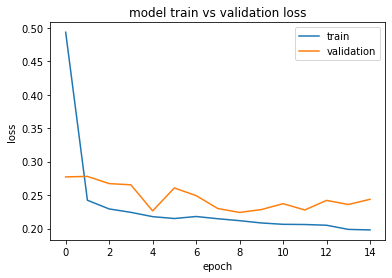

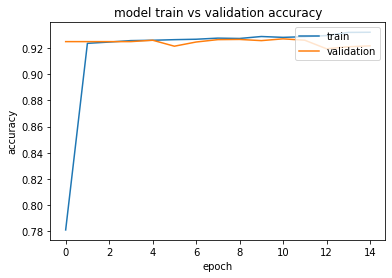

In [22]:
# (test_inputs, test_target_binar

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
y_pred = model.predict(x_test)

In [24]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
print(confusion_matrix(test_target_binary.argmax(axis=1), y_pred.argmax(axis=1)))
print('F1 score:',f1_score(test_target_binary.argmax(axis=1), y_pred.argmax(axis=1)))
print('Precision:',precision_score(test_target_binary.argmax(axis=1), y_pred.argmax(axis=1)))
print('Recall:',recall_score(test_target_binary.argmax(axis=1), y_pred.argmax(axis=1)))

[[8563  145]
 [ 595  105]]
F1 score: 0.2210526315789474
Precision: 0.42
Recall: 0.15
